Bayes naïf pour catégoriser les données. On suit les étapes décrites aux p.1-32 du document suivant :

https://d1b10bmlvqabco.cloudfront.net/paste/k50wrw2ed8r5ry/540377b9394397bffc17bdea2943f0814617eeec4c78da972e18c64e9c03d6ad/Jurafsky_-_Naive_Bayes_-_Text_classification.pdf

C'est de ce document qu'on parle dans le code quand on parle du "document".

In [33]:
import numpy as np
import pandas as pd
from scipy import sparse
import string
import math
import matplotlib.pyplot as plt # juste pour afficher des résultats

In [ ]:
# prétraitement des données : les 3 fonctions qui suivent prennent le dataset en transforment les données sous
# 'Abstract' par les abstracts en un numpy.array où chaque élément est un string d'un mot de l'article.
# Prend en considération les mots répétés plusieurs fois et enlève les mots communs qui ne veulent rien dire
# comme "it", "and", "we", etc.

# pour ponctuation
def pd_translate(df):
    df = df.replace(r'\n',' ', regex=True)
    punct = string.punctuation
    transtab = str.maketrans(dict.fromkeys(punct, ' '))
    return df.assign(
        Abstract='¿'.join(df['Abstract'].tolist()).translate(transtab).split('¿')
    )


#pour enlever les mots communs
def load_common_words(file):
    common_words = pd.read_csv(file,header=None)
    common_words = common_words[0].str.split(' ')
    return np.array(common_words[0])

# actual pré-traitement où on change le dataset pour de vrai
def pre_traitement(df, common_words):
    # Remove the punctuation, blank spaces and put everything in lowercase
    df = df.assign(Abstract=pd_translate(df)['Abstract'].str.lower())
    df = df.assign(Abstract=df['Abstract'].str.strip())
    df = df.replace(r'\s+',' ', regex=True)
    
    # Split each phrase in words
    df = df.assign(Abstract=df['Abstract'].str.split(' '))

    abstracts = []

    for article in df['Abstract'] :
        article = np.array(article)
        index = []
        for common_word in common_words :
            index = np.where(article == common_word)
            article = np.delete(article, index)
        abstracts.append(article)

    df = df.assign(Abstract=list(abstracts))

    return df
#### fin pré-traitement


# dictionnaire de la fréquence de chaque mot pour chaque catégorie d'articles
# e.g. on aura l'entrée {'astro-ph':{'energy:147'},...} si on l'applique au dataset de training
# il faut lire que le mot "energy" apparaît 147 fois parmi tous les articles d'astrophysique en tenant
# compte des répétitions (e.g. si un article dit 2 fois le mot energy, alors on ajoute 2 au compteur)
def create_category_maps(data):
    words_par_category = {}
    # Create an entry for each unique category
    for category in data['Category'].unique():
        df_cat = data.loc[data['Category'] == category]
        
        total_class_words = np.array([])
        
        # Add the word to a list for the category
        for row in df_cat['Abstract']:
            total_class_words = np.concatenate((total_class_words, row), axis=None)
        
        # Count the number of times a word is repeated in a category
        words_by_class = {}
        for (i, elem) in enumerate(total_class_words):
            if elem in words_by_class:
                words_by_class[elem] += 1
            else:
                words_by_class[elem] = 1
        
        words_par_category[category] = words_by_class
        
    return words_par_category


# nombre total de mots pour chaque catégorie (donc n de la p.32 du document)
def n_words_classes(dataset) :
    total_words_par_category = {}
    #iterate over all categories
    for category in dataset['Category'].unique() :
        dataset_cat = data.loc[data['Category'] == category]
        concatenated_abstracts = np.array([])
        # append all abstracts together
        for row in dataset_cat['Abstract'] :
            concatenated_abstracts = np.concatenate((concatenated_abstracts, row), axis=None)
        total_words_par_category[category] = concatenated_abstracts.size # total words for a particular class
    return total_words_par_category


# P(c), probability that a particular article is of a certain type when drawing a random article from dataset
# i.e. P(c_j) p.32 du document = |docs_j| / |total # doc|
def category_probability(dataset) :
    n_articles_par_category = {}
    n_articles_tot = len(dataset)
    for category in dataset['Category'].unique() :
        dataset_cat = data.loc[data['Category'] == category]
        n_articles_par_category[category] = len(dataset_cat) / n_articles_tot
    return n_articles_par_category


# returns |V|=|Vocabulary| (p.32 of doc), a scalar, total unique words in ALL training articles
def taille_V(dataset) :
    concatenated_unique_words = np.array([])
    for row in dataset['Abstract'] :
        # append the unique words of each article
        concatenated_unique_words = np.concatenate((concatenated_unique_words, np.unique(row)))
    # return the unique words from these words
    return(np.unique(concatenated_unique_words).size)

# probability to select a particular word when selecting a word from a certain class type article
# e.g. what is the probability of selecting the word "solar" when choosing a random word
# from all astrophysics articles? see p.32 of document
def prob_word_c(word, classe, V_size, alpha=1) :
    if word in category_maps[classe] :
        return (category_maps[classe][word] + alpha) / (total_words_par_class[classe] + alpha*V_size)
    else :
        return alpha / (total_words_par_class[classe] + alpha*V_size)

# returns index of max likelihood subject for given test example 
def prob_article_c(test_article, classes, p_class, V_size, alpha=1) :
    prob_word = np.zeros( (len(test_article), n_classes))
    for (i, word) in enumerate(test_article) :
        for (j, classe) in enumerate(unique_labels) :
            prob_word[i,j] = p_class[classe]*np.log(prob_word_c(word, classe, V_size, alpha)) # * prob_category
    return np.argmax(np.sum(prob_word, axis=0))

In [2]:
# prétraitement des données : les 3 fonctions qui suivent prennent le dataset en transforment les données sous
# 'Abstract' par les abstracts en un numpy.array où chaque élément est un string d'un mot de l'article.
# Prend en considération les mots répétés plusieurs fois et enlève les mots communs qui ne veulent rien dire
# comme "it", "and", "we", etc.

# pour ponctuation
def pd_translate(df):
    df = df.replace(r'\n',' ', regex=True)
    punct = string.punctuation
    transtab = str.maketrans(dict.fromkeys(punct, ' '))
    return df.assign(
        Abstract='¿'.join(df['Abstract'].tolist()).translate(transtab).split('¿')
    )


#pour enlever les mots communs
def load_common_words(file):
    common_words = pd.read_csv(file,header=None)
    common_words = common_words[0].str.split(' ')
    return np.array(common_words[0])

# actual pré-traitement où on change le dataset pour de vrai
def pre_traitement(df, common_words):
    # Remove the punctuation, blank spaces and put everything in lowercase
    df = df.assign(Abstract=pd_translate(df)['Abstract'].str.lower())
    df = df.assign(Abstract=df['Abstract'].str.strip())
    df = df.replace(r'\s+',' ', regex=True)
    
    # Split each phrase in words
    df = df.assign(Abstract=df['Abstract'].str.split(' '))

    abstracts = []

    for article in df['Abstract'] :
        article = np.array(article)
        index = []
        for common_word in common_words :
            index = np.where(article == common_word)
            article = np.delete(article, index)
        abstracts.append(article)

    df = df.assign(Abstract=list(abstracts))

    return df
#### fin pré-traitement


# dictionnaire de la fréquence de chaque mot pour chaque catégorie d'articles
# e.g. on aura l'entrée {'astro-ph':{'energy:147'},...} si on l'applique au dataset de training
# il faut lire que le mot "energy" apparaît 147 fois parmi tous les articles d'astrophysique en tenant
# compte des répétitions (e.g. si un article dit 2 fois le mot energy, alors on ajoute 2 au compteur)
def create_category_maps(data):
    words_par_category = {}
    # Create an entry for each unique category
    for category in data['Category'].unique():
        df_cat = data.loc[data['Category'] == category]
        
        total_class_words = np.array([])
        
        # Add the word to a list for the category
        for row in df_cat['Abstract']:
            total_class_words = np.concatenate((total_class_words, row), axis=None)
        
        # Count the number of times a word is repeated in a category
        words_by_class = {}
        for (i, elem) in enumerate(total_class_words):
            if elem in words_by_class:
                words_by_class[elem] += 1
            else:
                words_by_class[elem] = 1
        
        words_par_category[category] = words_by_class
        
    return words_par_category


# nombre total de mots pour chaque catégorie (donc n de la p.32 du document)
def n_words_classes(dataset) :
    total_words_par_category = {}
    #iterate over all categories
    for category in dataset['Category'].unique() :
        dataset_cat = data.loc[data['Category'] == category]
        concatenated_abstracts = np.array([])
        # append all abstracts together
        for row in dataset_cat['Abstract'] :
            concatenated_abstracts = np.concatenate((concatenated_abstracts, row), axis=None)
        total_words_par_category[category] = concatenated_abstracts.size # total words for a particular class
    return total_words_par_category


# P(c), probability that a particular article is of a certain type when drawing a random article from dataset
# i.e. P(c_j) p.32 du document = |docs_j| / |total # doc|
def category_probability(dataset) :
    n_articles_par_category = {}
    n_articles_tot = len(dataset)
    for category in dataset['Category'].unique() :
        dataset_cat = data.loc[data['Category'] == category]
        n_articles_par_category[category] = len(dataset_cat) / n_articles_tot
    return n_articles_par_category


# returns |V|=|Vocabulary| (p.32 of doc), a scalar, total unique words in ALL training articles
def taille_V(dataset) :
    concatenated_unique_words = np.array([])
    for row in dataset['Abstract'] :
        # append the unique words of each article
        concatenated_unique_words = np.concatenate((concatenated_unique_words, np.unique(row)))
    # return the unique words from these words
    return(np.unique(concatenated_unique_words).size)

# probability to select a particular word when selecting a word from a certain class type article
# e.g. what is the probability of selecting the word "solar" when choosing a random word
# from all astrophysics articles? see p.32 of document
def prob_word_c(word, classe, V_size, alpha=1) :
    if word in category_maps[classe] :
        return (category_maps[classe][word] + alpha) / (total_words_par_class[classe] + alpha*V_size)
    else :
        return alpha / (total_words_par_class[classe] + alpha*V_size)

# returns index of max likelihood subject for given test example 
def prob_article_c(test_article, classes, p_class, V_size, alpha=1) :
    prob_word = np.zeros( (len(test_article), n_classes))
    for (i, word) in enumerate(test_article) :
        for (j, classe) in enumerate(unique_labels) :
            prob_word[i,j] = p_class[classe]*np.log(prob_word_c(word, classe, V_size, alpha)) # * prob_category
    return np.argmax(np.sum(prob_word, axis=0))

Done


In [ ]:
# variables utiles plus tard
df= pd.read_csv("train.csv")                                  # données brutes (train)
common_words = load_common_words('common_english_words.txt')  # mots communs à enlever
unique_labels = df['Category'].unique()                       # liste des sujets
n_classes = len(unique_labels)                                # nombre de classes 
data = pre_traitement(df, common_words)                       # données pré-traitées (train)
category_maps = create_category_maps(data)                    # dictionnaire du nombre de fois que chaque mot apparaît pour chaque classe
total_words_par_class = n_words_classes(data)                 # nombre total de mots d'un type d'article en particulier
V_size = taille_V(data)                                       # |V| nombre de mots uniques dans TOUS les articles de training
cat_prob = category_probability(df)                           # probabilité de chaque sujet 

df_test = pd.read_csv("test.csv")                             # données brutes (test)
data_test = pre_traitement(df_test, common_words)             # données pré-traitées (test)

print('Done')

On est maintenant prêts à faire les prédictions. Pour ne pas gaspiller de soumissions sur Gradescope, on sépare notre dataset en deux parties : données de test (80%) et données de validation (20%). On va entraîner puis tester les données labeled pour s'assurer que tout fonctionne bien. En plus, on fera un petit scan de l'hyperparamètre alpha pour choisir une valeur optimale de ce paramètre. C'est le seul hyperparamètre du problème*, donc on peut simplement choisir quelques valeurs arbitraires de alpha et choisir celle qui a le meilleur résultat dans les données de validation.

\* Il y a aussi l'hyperparamètre de quels mots on veut enlever (common words), mais on ne touche pas à ca, très compliqué d'en tirer des conclusions et on en parle un peu plus dans le rapport.

In [20]:
# séparer les données en train+validation
sep = int(4*len(data)/5)
train_data = data.iloc[:sep]
val_data = data.iloc[sep:]

# créer les dictionnaires de mots, trouver n et |V| pour ces datasets
category_maps = create_category_maps(train_data)
total_words_par_class = n_words_classes(train_data)
V_size = taille_V(train_data)

In [28]:
# trouver les prédictions pour le validation set (attention aux indices car le validation set est un
# sous-ensemble des données de training) en utilisant quelques alphas différents
alpha_table = [0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10, 20]
n_alpha = len(alpha_table)
n_val = len(val_data)
predictions_val = np.ones((n_alpha, n_val))
for j in range(n_alpha) :
    for i in range(sep,len(data)) :
        predictions_val[j, i-sep] = prob_article_c(val_data['Abstract'][i], unique_labels, cat_prob, V_size, alpha_table[j])
print(predictions_val)
predictions_val_string = unique_labels[np.array(predictions_val, dtype='int')] # prédictions human-friendly
print(predictions_val_string)

[[ 0. 10.  0. ...  5.  3.  5.]
 [ 0. 10.  8. ...  5.  3.  5.]
 [ 8. 10.  8. ...  5.  3.  5.]
 ...
 [ 8. 10.  8. ...  5.  3.  5.]
 [14. 10. 14. ...  5.  3.  5.]
 [14. 10. 14. ...  5.  3.  3.]]
[['astro-ph' 'astro-ph.SR' 'astro-ph' ... 'hep-th' 'math.CO' 'hep-th']
 ['astro-ph' 'astro-ph.SR' 'astro-ph.CO' ... 'hep-th' 'math.CO' 'hep-th']
 ['astro-ph.CO' 'astro-ph.SR' 'astro-ph.CO' ... 'hep-th' 'math.CO'
  'hep-th']
 ...
 ['astro-ph.CO' 'astro-ph.SR' 'astro-ph.CO' ... 'hep-th' 'math.CO'
  'hep-th']
 ['astro-ph.GA' 'astro-ph.SR' 'astro-ph.GA' ... 'hep-th' 'math.CO'
  'hep-th']
 ['astro-ph.GA' 'astro-ph.SR' 'astro-ph.GA' ... 'hep-th' 'math.CO'
  'math.CO']]


In [29]:
# comparer aux vrais labels du validation set
predictions_val_string == np.array(val_data['Category'])

array([[False,  True, False, ...,  True,  True,  True],
       [False,  True, False, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True, False]])

In [31]:
# calculer le taux de réussite
efficacite = np.sum(predictions_val_string == np.array(val_data['Category']), axis=1) / 1500
efficacite

array([0.77266667, 0.78933333, 0.786     , 0.78333333, 0.77933333,
       0.77733333, 0.744     , 0.72066667])

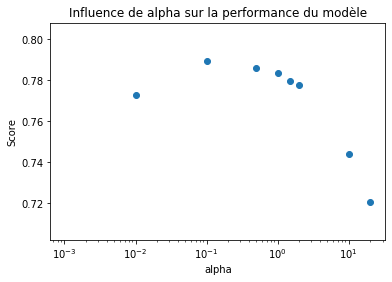

In [50]:
# Graphique pour le rapport : influence de alpha sur la performance du modèle
# on utilise matplotlib (bibliothèque interdite pour le modèle) mais c'est juste pour afficher les résultats
plt.figure('alpha')
plt.scatter(alpha_table, efficacite)
plt.xscale('log')
plt.title('Influence de alpha sur la performance du modèle') # pas de $\alpha$ car jupyter notebook est picky, mes excuses...
plt.xlabel('alpha')
plt.ylabel('Score')
plt.savefig('influence_alpha.png')
#plt.grid()

Rendus ici, on sait que notre code n'a pas de bug grave et qu'il fonctionne assez bien. On a des taux de réussite semblables aux scores que l'on voit sur Kaggle des autres équipes! En plus, on voit que n'importe quel alpha entre 0.1 et 2 donne des scores très semblables et optimaux. Les dernières lignes de code ne sont pas vraiment nécessaires pour la correction du rapport mais elles montrent ce qui a été fait pour obtenir les prédictions finales pour la compétition Kaggle, utilisant tout le dataset de training pour entraîner et les données de test pour les prédictions. On utilise alpha=1 même si alpha=0.1 performe très légèrement mieux.

In [3]:
##### Les prédictions finales sur les données de test!
n_test = len(data_test)
predictions_test = np.ones(n_test)
for i in range(n_test) :
    predictions_test[i] = prob_article_c(data_test['Abstract'][i], unique_labels, cat_prob, V_size)
print(predictions_test)

[ 6. 10. 10. ...  0.  9.  4.]


In [4]:
# human-friendly
predictions_string = unique_labels[np.array(predictions_test, dtype='int')]
predictions_string

array(['stat.ML', 'astro-ph.SR', 'astro-ph.SR', ..., 'astro-ph', 'gr-qc',
       'cond-mat.mes-hall'], dtype=object)

In [5]:
# créer un fichier .csv tel que requis
predictions_dict = {'Id' : np.arange(len(predictions_string)), 'Category' : predictions_string}
predictions_dict

{'Id': array([    0,     1,     2, ..., 14997, 14998, 14999]),
 'Category': array(['stat.ML', 'astro-ph.SR', 'astro-ph.SR', ..., 'astro-ph', 'gr-qc',
        'cond-mat.mes-hall'], dtype=object)}

In [6]:
# vérifications et visualisation du dataframe
predictions_test_dataframe = pd.DataFrame(predictions_dict, columns = ['Id', 'Category'])
predictions_test_dataframe

,Id,Category
0,0,stat.ML
1,1,astro-ph.SR
2,2,astro-ph.SR
3,3,math.AP
4,4,cs.LG
...,...,...
14995,14995,astro-ph.CO
14996,14996,physics.optics
14997,14997,astro-ph
14998,14998,gr-qc


In [7]:
# exportation sous csv et lecture du doc pour s'assurer qu'il est du bon format pour pas gaspiller une évaluation
# Kaggle sur des niaiseries de tailles incompatibles
predictions_test_dataframe.to_csv('predictions_bayes_naif_test_set.csv', index=False)
dti = pd.read_csv('predictions_bayes_naif_test_set.csv')
dti

,Id,Category
0,0,stat.ML
1,1,astro-ph.SR
2,2,astro-ph.SR
3,3,math.AP
4,4,cs.LG
...,...,...
14995,14995,astro-ph.CO
14996,14996,physics.optics
14997,14997,astro-ph
14998,14998,gr-qc
